# Bayesian Analysis of Variable Growth Rate
The assumption of continuous unlimited growth with a maximum growth rate $\mu_{max}$ often does not hold in reality.
Even *Corynebacterium glutamicum* exhibits an overshoot in the transition into the stationary phase that is not explained by most growth models.

This notebook demonstrates how `bletl_analysis.models.fit_mu_t` can be used to infer the specific growth rate over time $\mu(t)$ from backscatter measurements.
Internally, this is done with [PyMC3](https://docs.pymc.io) and requires a `calibr8` error model that models the relationship between cell dry weight and backscatter.

To install PyMC3, run these commands:
```
conda install -c conda-forge m2w64-toolchain
pip install "pymc3>=3.9.2"
```
Optionally (for visualization of the model), you can install Graphviz and pydot:
```
conda install -c conda-forge python-graphviz
pip install pydot
```

Author: Michael Osthege, 2020

In [1]:
# autoreload to hot-load changes from the bletl source code
%load_ext autoreload
%autoreload 2
# use the full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy
from matplotlib import pyplot, cm
import pathlib
import pymc3
import arviz

import bletl_pro as bletl
import bletl_analysis
# the `models` submodule must be imported explicitly because is uses optional dependencies:
import bletl_analysis.models
import calibr8
import calibr8_contrib

## The Data
An error model for the CDW/Backscatter correlation at the experiment settings (Pahpshmir BioLector, 1400 rpm\*, *Corynebacterium&nbsp;glutamicum*&nbsp;WT) is loaded from `calibr8_contrib`.

_(*The experiment actually ran at 1300 rpm, but we don't have an error model for that. But this is just an example, so it's fine.)_

This example uses a BioLector Pro test dataset from `bletl`.
The well `D06` that is analyzed was oxygen-limited in the late exponential phase.

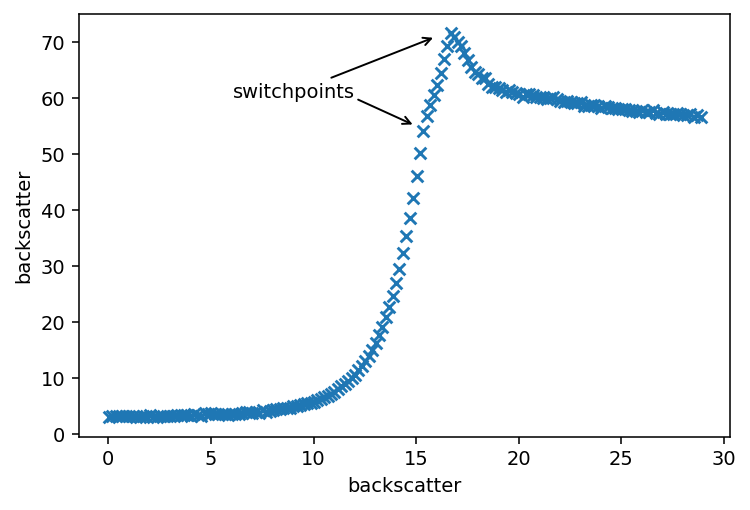

In [3]:
em_cdw = calibr8_contrib.get_model('2020-08-09_Pahpshmir_1400_BS3_CgWT')
# rename the dependent key for less clutter:
em_cdw.dependent_key = 'BS3'

bldata = bletl.parse(
    pathlib.Path(r'..\bletl_pro\tests\data\BLPro\22-HM_Coryne_Batch_O2Up-HM-2018-05-09-08-56-27.csv'),
)
bs3 = bldata['BS3']
t, y = bs3.get_timeseries('D06')

fig, ax = pyplot.subplots(dpi=140)
ax.scatter(t, y, marker='x')
ax.set_ylabel('backscatter')
ax.set_xlabel('backscatter')
ax.annotate("", xy=(15, 55), xytext=(12, 60), arrowprops=dict(arrowstyle="->"))
ax.annotate("switchpoints", xy=(16, 71), xytext=(12, 60), arrowprops=dict(arrowstyle="->"), horizontalalignment='right')
pyplot.show()

## Fitting
The fitting is done with the `fit_mu_t` convenience function from `bletl_analysis.models`.
It takes the time- and backscatter vectors of the data along with the `calibr8` error model and a manually specified list of switchpoint-times.

The model describes the timeseries of biomass $X_t$ as a function from two parameters $X_0$ and $\vec{\mu_t}$ where $\vec{\mu_t}$ is the concatenation of growth rate vectors for individual phases:
$$\vec{\mu_t} = concat(\vec{\mu}_{phase\ 0}, \ldots, \vec{\mu}_{phase\ n}, \vec{\mu}_{stationary})$$
The biomass timeseries is calculated from a cumulative sum:
$$ \vec{X_t} = X_0 + X_0 \cdot e^{cumsum(\vec{\mu_t}\cdot \vec{dt})} $$


The $\vec{\mu_t}$ vectors of individual phases are described by either a Gaussian or StudentT [random walk](https://en.wikipedia.org/wiki/Random_walk).
If a `StudentT` random walk is used, the model can automatically detect switchpoints in the growth rate.

Most *Corynebacterium* curves have a switchpoint when the substrate is depleted.
Conveniently, this switchpoint falls together with the highest backscatter value, so we can get its time with `t[numpy.argmax(y)]`.

In [4]:
result = bletl_analysis.models.fit_mu_t(
    t, y, em_cdw,
    # the (optional) switpoints may be a sequence, or dict:
    switchpoints=[
        t[numpy.argmax(y)],
    ],
    # when switchpoints are set, it defaults to a Gaussian random walk
    # by enforcing the StudentT random walk, we can detect _additional_ switchpoints:
    student_t=True,
)

### Interpreting the Result
The returned object is a `bletl_analysis.models.GrowthRateResult` that has all relevant variables available attached as properties.
You can run `help(result)` to get a full description.

The `result.pmodel` property is the PyMC3 model object, which is visualized in the next cell.
From this so called _plate model_ you can see that the length 173 `mu_t` is modeled from two shorter fragments, a length 101 `mu_phase_0` and a length 73 `mu_stationary`.

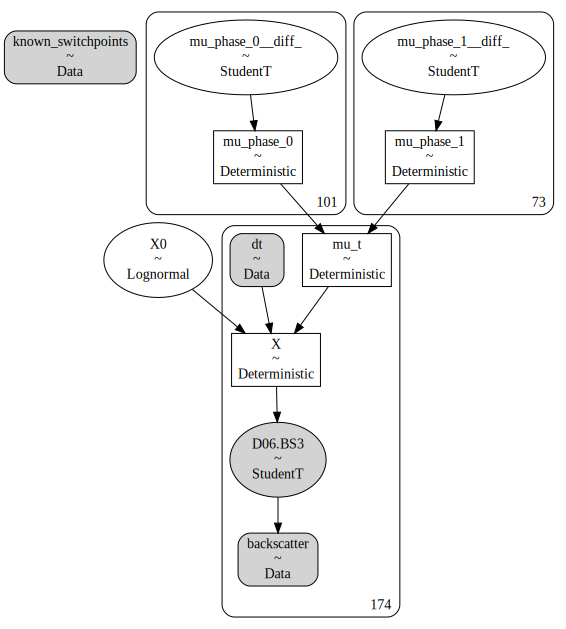

In [5]:
plot = pymc3.model_to_graphviz(result.pmodel)
display(plot)

### Visualizing the Result
With the default settings, the `fit_mu_t` function just fitted the *maximum-a-posteriori* (MAP) estimate to the data.
This is the *best fit* and can be plotted directly from `result.mu_map` and a few additional properties:

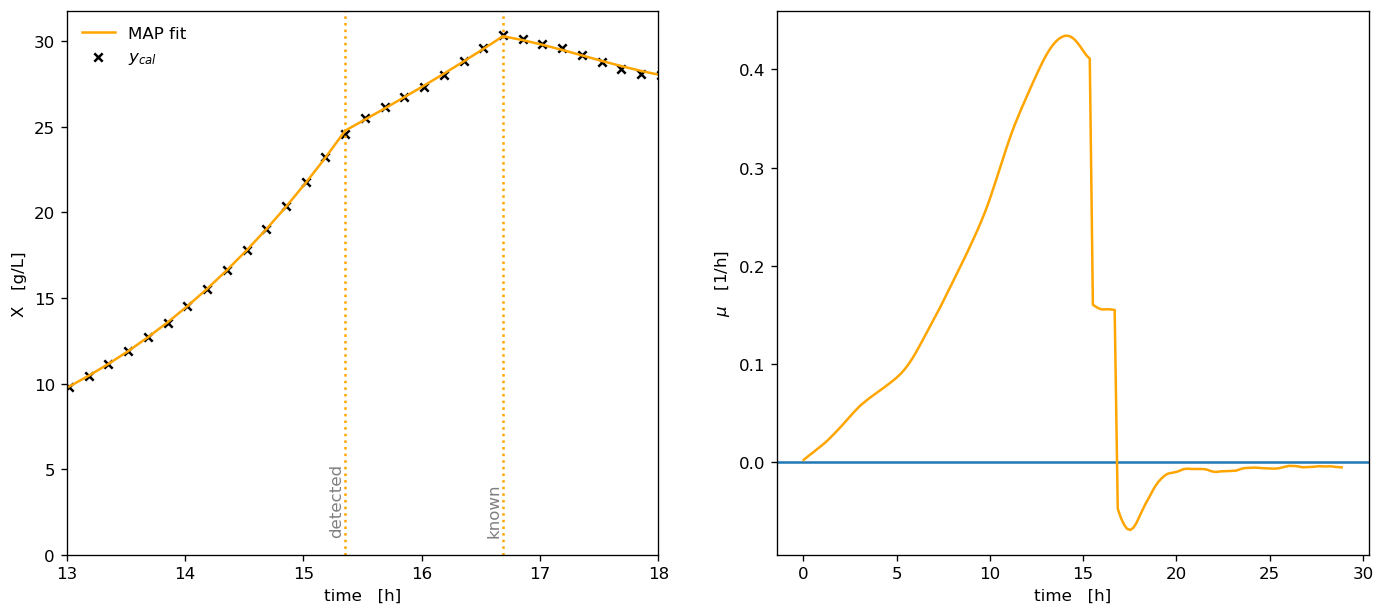

In [6]:
fig, (left, right) = pyplot.subplots(ncols=2, figsize=(14,6), dpi=120)

# backscatter observations are translated to CDW via `predict_independent`
left.scatter(t, em_cdw.predict_independent(y), s=25, label='$y_{cal}$', marker='x', color='black')
left.plot(t, result.x_map, color='orange', label='MAP fit')

left.set_ylabel('X   [g/L]')
left.set_xlabel('time   [h]')
left.legend(loc='upper left', frameon=False)
left.set_ylim(0)
right.axhline(0)

right.plot(t, result.mu_map, color='orange', label='MAP fit')
right.set_ylabel('$\mu$   [1/h]')
right.set_xlabel('time   [h]')

# draw vertical lines at the (detected) switchpoints
for t_switch, label in result.switchpoints.items():
    left.axvline(t_switch, linestyle=':', color='orange', label=label)
    left.text(
        t_switch, 1,
        s=f'{label}\n',
        color="gray",
        rotation=90,
        horizontalalignment="center",
        verticalalignment='bottom',
    )
    
# zoom in on the range containing the switchpoints
left.set_xlim(13,18) 
#right.set_xlim(13,18)

pyplot.show()

### Sampling the _posterior_ probability distribution of $\mu_t$
The `GrowthRateResult` object has a convenience function that may be called to run MCMC sampling.
This sampling is not executed by default, because it takes significantly longer than the MAP estimation. For models with `StudentT` random walks, the MCMC sampling is much slower than for models with `Gaussian` random walks!

With `result.sample()` you can run the default settings.
Any keyword-arguments will be forwarded to the `pymc3.sample` call, if you want to customize.

In [7]:
result.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [X0, mu_phase_1__diff_, mu_phase_0__diff_]


Sampling 3 chains for 500 tune and 500 draw iterations (1_500 + 1_500 draws total) took 2442 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


You can save the sampling result with [ArviZ](https://arviz-devs.github.io/arviz/) for reproducing the analysis later:

In [8]:
result.idata.to_netcdf(f'Analysis_BayesianVariableGrowthRate.nc')

'Analysis_BayesianVariableGrowthRate.nc'

### Visualizing the $\mu_t$ posterior distribution
The posterior samples are accessible as a 2D array via `result.mu_mcmc` and can be plotted conveniently using the `pymc3.gp.util.plot_gp_dist` helper function.

The following plot also shows the DO profile that explains why the growth rate suddenly breaks down before depletion of the carbon source.

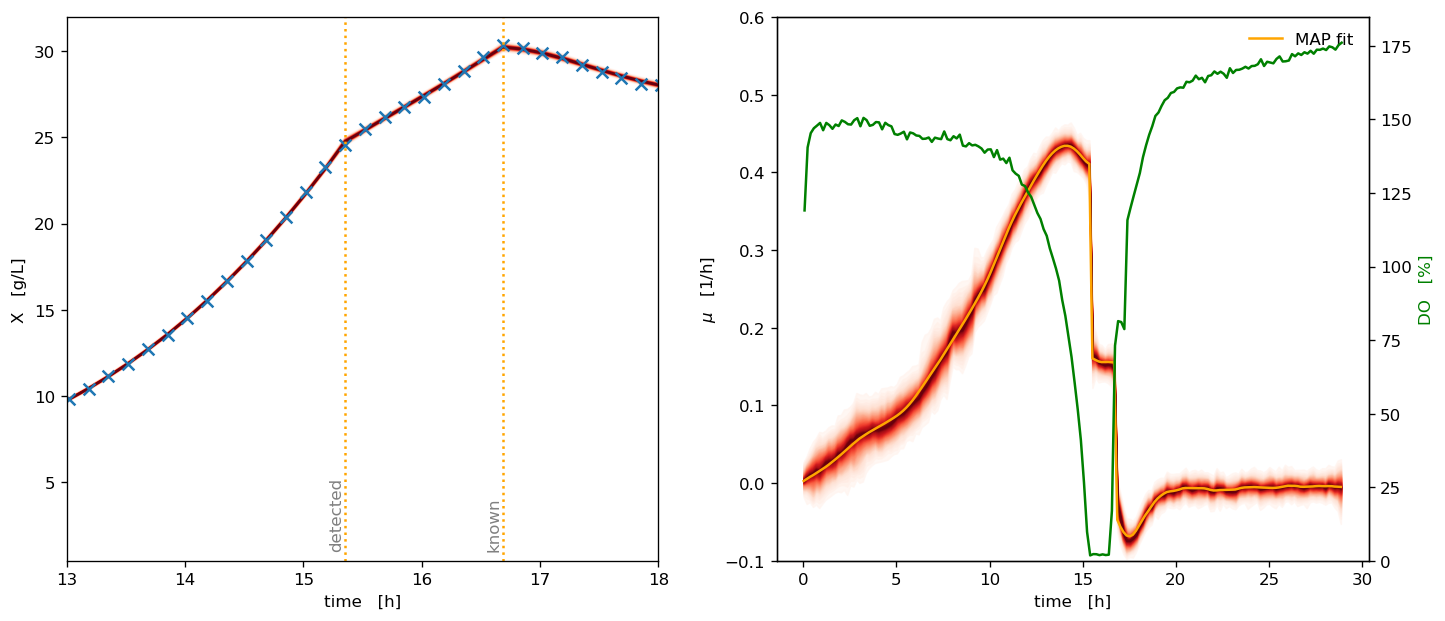

In [9]:
fig, (left, right) = pyplot.subplots(ncols=2, figsize=(14,6), dpi=120)

pymc3.gp.util.plot_gp_dist(
    ax=left,
    x=t,
    samples=result.x_mcmc,
    samples_alpha=0,
)
left.scatter(t, em_cdw.predict_independent(y), s=50, label='$y_{cal}$', marker='x')
left.set_ylabel('X   [g/L]')
left.set_xlabel('time   [h]')
# draw vertical lines at switchpoints
for t_switch, label in result.switchpoints.items():
    left.axvline(t_switch, linestyle=':', color='orange', label=label)
    left.text(
        t_switch, 1,
        s=f'{label}\n',
        color="gray",
        rotation=90,
        horizontalalignment="center",
        verticalalignment='bottom',
    )

pymc3.gp.util.plot_gp_dist(
    ax=right,
    x=t,
    samples=result.mu_mcmc,
    samples_alpha=0,
)
right.plot(t, result.mu_map, color='orange', label='MAP fit')
right.set_ylabel('$\mu$   [1/h]')
right.set_xlabel('time   [h]')
right.set_ylim(-0.1, 0.6)
right.legend(frameon=False)

# plot the DO curve for comparison
tdo, do = bldata['DO'].get_timeseries('D06')
right2 = right.twinx()
right2.plot(tdo, do, color='green')
right2.set_ylim(0)
right2.set_ylabel('DO   [%]', color='green')

# zoom in on the switchpoints
left.set_xlim(13,18)

pyplot.show()

The comparison of posterior distribution and MAP estimate is consistent, indicating that the MAP estimate can be used for a quick look, before hitting the computationally expensive inference button™.

### MCMC Diagnostics
If the sampling returned any warnings about convergence or sample size, you can create diagnostic plots with ArviZ.

In this case the convergence doesn't look great - for a publication you should take more draws, or switch to Gaussian random walks with manually specified switchpoints.

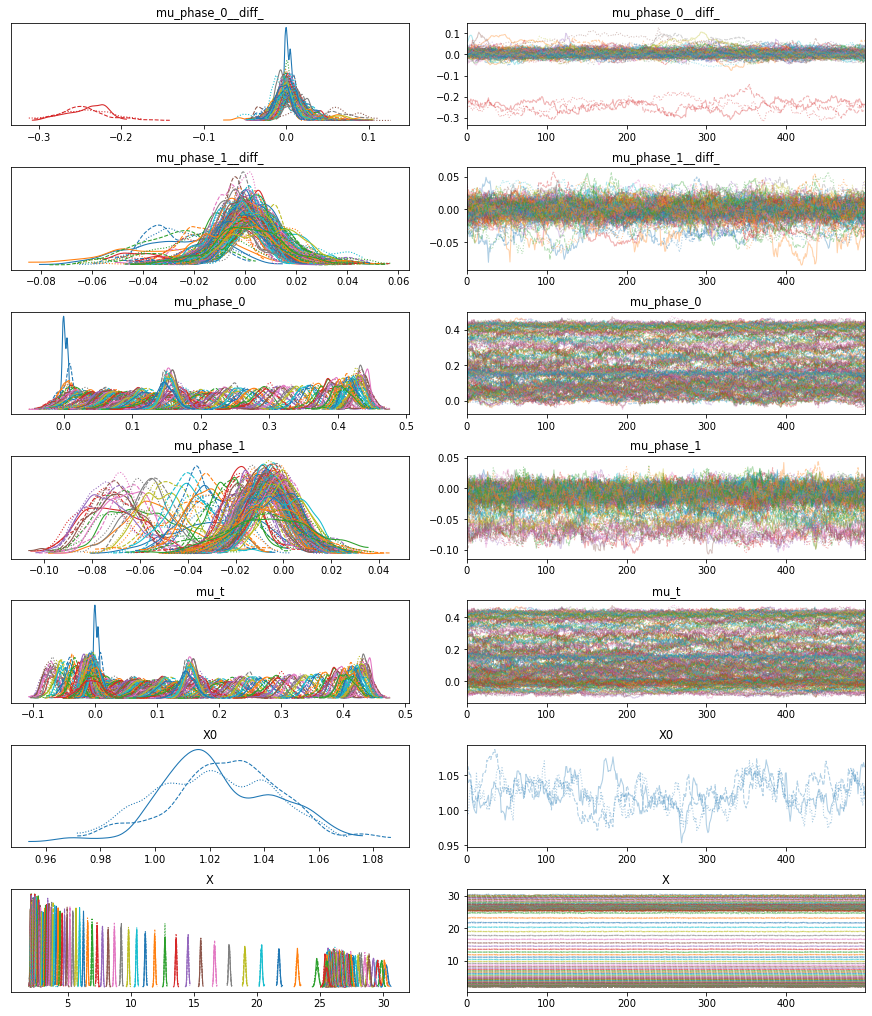

In [10]:
arviz.plot_trace(result.idata, compact=True);

In [11]:
# this cell prints the date of the last run and the version numbers of relevant packages
# to execute this cell you need the `watermark` package (pip install watermark)
%load_ext watermark
%watermark -n -u -v -iv -w

numpy           1.18.5
bletl_pro       0.3.7
arviz           0.9.0
bletl_analysis  1.1.0
calibr8         4.1.0
calibr8_contrib 0.1.0
pymc3           3.9.2
last updated: Wed Aug 12 2020 

CPython 3.7.7
IPython 7.16.1
watermark 2.0.2
